![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de popularidad en canción

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de popularidad en canción".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/competitions/miad-2025-12-prediccion-popularidad-en-cancion).

## Datos para la predicción de popularidad en cancion

En este proyecto se usará el conjunto de datos de datos de popularidad en canciones, donde cada observación representa una canción y se tienen variables como: duración de la canción, acusticidad y tempo, entre otras. El objetivo es predecir qué tan popular es la canción. Para más detalles puede visitar el siguiente enlace: [datos](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/dataTrain_Spotify.csv')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/dataTest_Spotify.csv', index_col=0)

### 1. Preprocesamiento de datos

In [4]:
# Visualización datos de entrenamiento
dataTraining.head()

,Unnamed: 0,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity
0,0,7hUhmkALyQ8SX9mJs5XI3D,Love and Rockets,Love and Rockets,Motorcycle,211533,False,0.305,0.8490,9,...,1,0.0549,0.000058,0.056700,0.4640,0.3200,141.793,4,goth,22
1,1,5x59U89ZnjZXuNAAlc8X1u,Filippa Giordano,Filippa Giordano,"Addio del passato - From ""La traviata""",196000,False,0.287,0.1900,7,...,0,0.0370,0.930000,0.000356,0.0834,0.1330,83.685,4,opera,22
2,2,70Vng5jLzoJLmeLu3ayBQq,Susumu Yokota,Symbol,Purple Rose Minuet,216506,False,0.583,0.5090,1,...,1,0.0362,0.777000,0.202000,0.1150,0.5440,90.459,3,idm,37
3,3,1cRfzLJapgtwJ61xszs37b,Franz Liszt;YUNDI,Relajación y siestas,"Liebeslied (Widmung), S. 566",218346,False,0.163,0.0368,8,...,1,0.0472,0.991000,0.899000,0.1070,0.0387,69.442,3,classical,0
4,4,47d5lYjbiMy0EdMRV8lRou,Scooter,Scooter Forever,The Darkside,173160,False,0.647,0.9210,2,...,1,0.1850,0.000939,0.371000,0.1310,0.1710,137.981,4,techno,27


In [5]:
dataTraining.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79800 entries, 0 to 79799
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        79800 non-null  int64  
 1   track_id          79800 non-null  object 
 2   artists           79800 non-null  object 
 3   album_name        79800 non-null  object 
 4   track_name        79800 non-null  object 
 5   duration_ms       79800 non-null  int64  
 6   explicit          79800 non-null  bool   
 7   danceability      79800 non-null  float64
 8   energy            79800 non-null  float64
 9   key               79800 non-null  int64  
 10  loudness          79800 non-null  float64
 11  mode              79800 non-null  int64  
 12  speechiness       79800 non-null  float64
 13  acousticness      79800 non-null  float64
 14  instrumentalness  79800 non-null  float64
 15  liveness          79800 non-null  float64
 16  valence           79800 non-null  float6

In [6]:
# Revisar duplicados
dataTraining.duplicated().sum()

0

In [7]:
# Revisar nulos
dataTraining.isnull().sum()

Unnamed: 0          0
track_id            0
artists             0
album_name          0
track_name          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
popularity          0
dtype: int64

In [8]:
# Estadísticas generales
dataTraining.describe() 

,Unnamed: 0,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity
count,79800.000000,7.980000e+04,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000,79800.000000
mean,39899.500000,2.279022e+05,0.567318,0.641529,5.307043,-8.263741,0.637732,0.084750,0.314979,0.157319,0.213313,0.474267,122.076559,3.902556,33.265301
std,23036.420078,1.050599e+05,0.173110,0.251441,3.562186,5.035504,0.480659,0.105657,0.332512,0.310792,0.190075,0.259010,29.941937,0.434284,22.330871
min,0.000000,1.338600e+04,0.000000,0.000019,0.000000,-49.307000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19949.750000,1.744360e+05,0.456000,0.472000,2.000000,-10.006000,0.000000,0.035900,0.017000,0.000000,0.097900,0.261000,99.081250,4.000000,17.000000
50%,39899.500000,2.128130e+05,0.581000,0.685000,5.000000,-7.012000,1.000000,0.049000,0.169000,0.000041,0.132000,0.464000,122.009000,4.000000,35.000000
75%,59849.250000,2.614260e+05,0.695000,0.854000,8.000000,-5.000000,1.000000,0.084500,0.598000,0.050500,0.273000,0.684000,140.054000,4.000000,50.000000
max,79799.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,222.605000,5.000000,100.000000


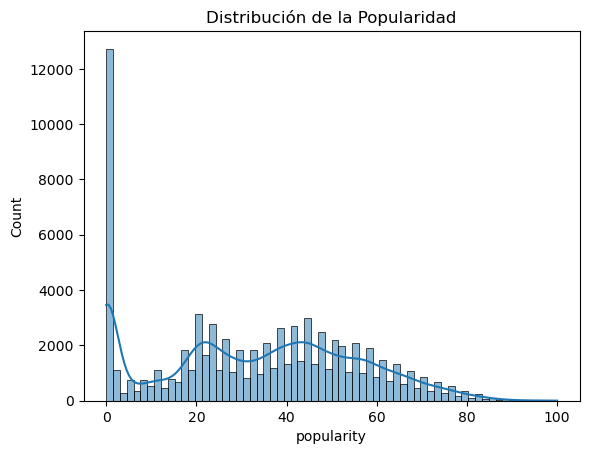

In [9]:
# Distribución de la variable objetivo
sns.histplot(dataTraining['popularity'], kde=True)
plt.title('Distribución de la Popularidad')
plt.show() 

<Axes: >

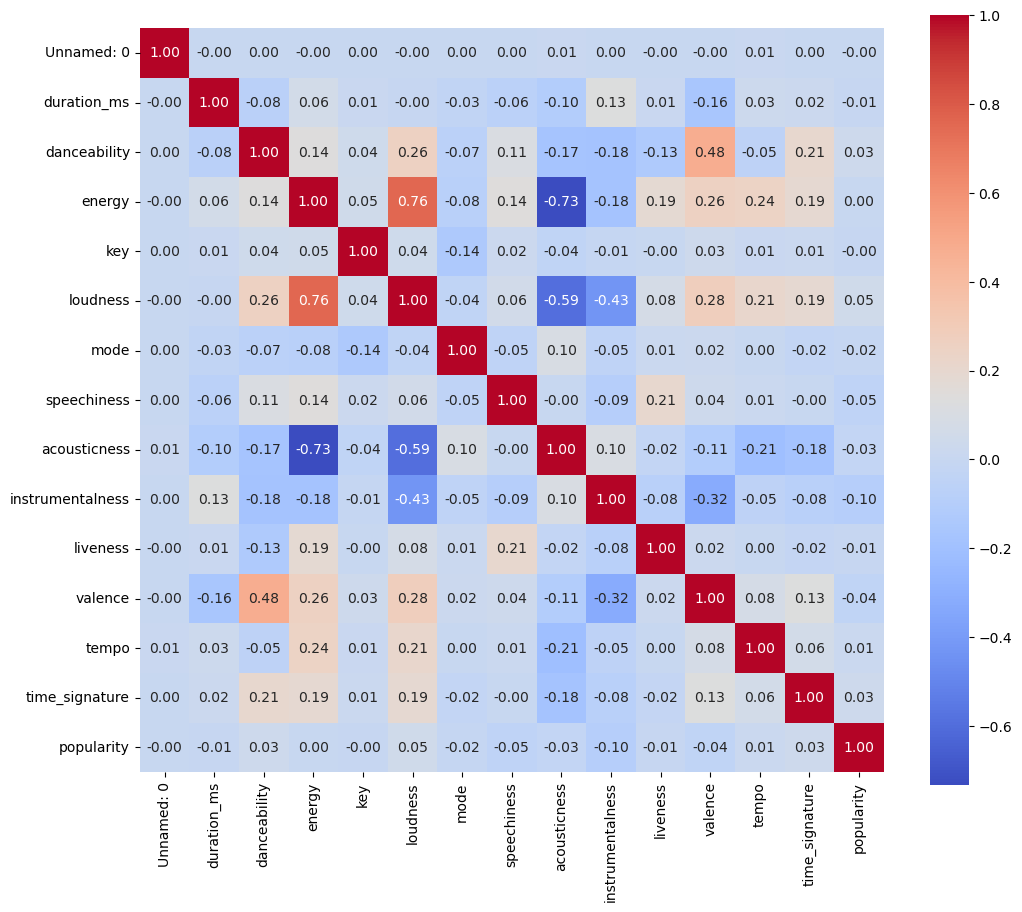

In [10]:
corr = dataTraining.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", square=True)

In [11]:
# Copia de seguridad
df = dataTraining.copy()

# Transformaciones no lineales
dataTraining['log_duration'] = np.log1p(dataTraining['duration_ms'])  # log transform para duración
dataTraining['sqrt_loudness'] = np.sqrt(dataTraining['loudness'].clip(lower=0))  # evitas NaN
dataTraining['tempo_squared'] = dataTraining['tempo'] ** 2

# Interacciones entre variables
dataTraining['energy_dance'] = dataTraining['energy'] * dataTraining['danceability']
dataTraining['valence_energy'] = dataTraining['valence'] * dataTraining['energy']
dataTraining['speech_acoustic'] = dataTraining['speechiness'] * dataTraining['acousticness']
dataTraining['tempo_mode'] = dataTraining['tempo'] * dataTraining['mode']

# Codificación de variables categóricas -Codificación de frecuencia para género
genre_counts = dataTraining['track_genre'].value_counts()
dataTraining['genre_freq'] = dataTraining['track_genre'].map(genre_counts)

# Estadísticas por artista
dataTraining['artist_mean_popularity'] = dataTraining.groupby('artists')['popularity'].transform('mean')

# Selección final de variables para modelado
feature_cols = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
    'log_duration', 'sqrt_loudness', 'tempo_squared',
    'energy_dance', 'valence_energy', 'speech_acoustic', 'tempo_mode',
    'genre_freq', 'artist_mean_popularity'
]

In [ ]:
X = dataTraining[feature_cols]
y = dataTraining['popularity']

In [12]:
# Unificar antes del split
X = pd.get_dummies(X, columns=['key', 'time_signature'], drop_first=True)

In [13]:
# Separar conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

### 2. Calibración del modelo

In [14]:
rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestRegressor(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
print("Mejores parámetros RF:", rf_grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores parámetros RF: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 500}


### 3. Entrenamiento del modelo

##### Se entrena el modelo escogido con los datos del set de entrenamiento preprocesados y los parámetros óptimos. 

In [15]:
# Entrenar el modelo en el conjunto de entrenamiento
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_estimators=500, random_state=42)

##### Desempeño del modelo en los datos de validación con al menos una métrica de desempeño.

In [72]:
y_pred_rf = best_rf.predict(X_val)

rmse_rf = mean_squared_error(y_val, y_pred_rf, squared=False)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
r2_rf = r2_score(y_val, y_pred_rf)

print(f"RMSE RF: {rmse_rf:.3f}")
print(f"MAE RF: {mae_rf:.3f}")
print(f"R² RF: {r2_rf:.3f}")

RMSE RF: 10.274
MAE RF: 5.284
R² RF: 0.787


##### Justificación de la selección del modelo .

## XGBoost

### 2. Calibración del modelo

In [21]:
xgb_params = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1)
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [22]:
# Entrenar el modelo en el conjunto de entrenamiento
best_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [69]:
y_pred_xgb = best_xgb.predict(X_val)

rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
r2_xgb = r2_score(y_val, y_pred_xgb)

print(f"RMSE XGB:, {rmse_xgb:.3f}") 
print(f"MAE XGB:, {mae_xgb:.3f}")
print(f"R² XGB:, {r2_xgb:.3f}")

RMSE XGB:, 10.245
MAE XGB:, 5.374
R² XGB:, 0.788


In [23]:
# Visualización datos de test
dataTesting.head()

,track_id,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,6KwkVtXm8OUp2XffN5k7lY,Hillsong Worship,No Other Name,No Other Name,440247,False,0.369,0.598,7,-6.984,1,0.0304,0.00511,0.000000,0.176,0.0466,148.014,4,world-music
1,2dp5I5MJ8bQQHDoFaNRFtX,Internal Rot,Grieving Birth,Failed Organum,93933,False,0.171,0.997,7,-3.586,1,0.1180,0.00521,0.801000,0.420,0.0294,122.223,4,grindcore
2,5avw06usmFkFrPjX8NxC40,Zhoobin Askarieh;Ali Sasha,Noise A Noise 20.4-1,"Save the Trees, Pt. 1",213578,False,0.173,0.803,9,-10.071,0,0.1440,0.61300,0.001910,0.195,0.0887,75.564,3,iranian
3,75hT0hvlESnDJstem0JgyR,Bryan Adams,All I Want For Christmas Is You,Merry Christmas,151387,False,0.683,0.511,6,-5.598,1,0.0279,0.40600,0.000197,0.111,0.5980,109.991,3,rock
4,4bY2oZGA5Br3pTE1Jd1IfY,Nogizaka46,バレッタ TypeD,月の大きさ,236293,False,0.555,0.941,9,-3.294,0,0.0481,0.48400,0.000000,0.266,0.8130,92.487,4,j-idol


In [24]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
np.random.seed(42)
y_pred = pd.DataFrame(np.random.rand(dataTesting.shape[0]) * 100, index=dataTesting.index, columns=['Popularity'])

In [ ]:
# Guardar predicciones en formato exigido en la competencia de kaggle
y_pred.to_csv('test_submission_file.csv', index_label='ID')
y_pred.head()